# Code to train and evaluate the model

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

## Common variables

In [2]:
seed = 45

data_category = pd.read_csv('data/info_category.csv', delimiter=';', decimal=".") 

In [3]:
def prepare_data(file_name, data_category):
    data = pd.read_csv(file_name+'.csv', delimiter=';', decimal=".") 
    data = data_category.merge(data, left_on=['img_name','folder','image'], right_on=['img_name','folder','image'])
    data[['category']] =  data[['category']]-1
    return data

## Grid search of parameters of the model

In [4]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

file_name = 'data/info_h_40'
sections_width = int(file_name.split("_")[-1])
data = prepare_data(file_name, data_category)
size_m = sections_width
X_values = data[['h_'+str(a) for a in range(1,size_m+1)]]
y_values = data[['category']]
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

#parameters = {'n_neighbors':range(3,7), 'p':[1,2,4]}
parameters = {'C':range(1,10), 'class_weight':['balanced', None]}
svc = SVC(random_state=seed)#KNeighborsClassifier()
clf = GridSearchCV(svc, parameters, scoring='precision_weighted', cv=12)
clf.fit(X_values, y_values.values.ravel())

data = pd.DataFrame(clf.cv_results_)
data.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,...,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,mean_test_score,std_test_score,rank_test_score
14,0.001752,0.002753,0.002028,0.003513,8,balanced,"{'C': 8, 'class_weight': 'balanced'}",0.827068,0.789474,0.954887,...,0.929825,1.000000,0.957895,0.739815,0.951389,0.858586,0.853175,0.883058,0.074541,1
16,0.000892,0.001056,0.004062,0.004062,9,balanced,"{'C': 9, 'class_weight': 'balanced'}",0.827068,0.789474,0.954887,...,0.929825,1.000000,0.957895,0.739815,0.951389,0.858586,0.853175,0.883058,0.074541,1
1,0.002746,0.000434,0.001744,0.000586,1,None,"{'C': 1, 'class_weight': None}",0.827068,0.673684,0.954887,...,0.929825,1.000000,1.000000,0.796296,0.951389,0.858586,0.805556,0.882669,0.091744,3
17,0.002736,0.003644,0.001884,0.003349,9,None,"{'C': 9, 'class_weight': None}",0.861842,0.673684,1.000000,...,0.869674,1.000000,0.957895,0.796296,0.951389,0.858586,0.896825,0.881539,0.089745,4
12,0.001071,0.001071,0.004060,0.004060,7,balanced,"{'C': 7, 'class_weight': 'balanced'}",0.827068,0.789474,0.921053,...,0.929825,1.000000,0.957895,0.739815,0.951389,0.858586,0.853175,0.880239,0.072379,5
5,0.002742,0.000433,0.001745,0.000432,3,None,"{'C': 3, 'class_weight': None}",0.804511,0.673684,1.000000,...,0.869674,1.000000,1.000000,0.796296,0.951389,0.858586,0.805556,0.879536,0.095917,6
2,0.002910,0.000276,0.001744,0.000432,2,balanced,"{'C': 2, 'class_weight': 'balanced'}",0.827068,0.737480,0.921053,...,0.929825,1.000000,0.957895,0.883333,0.871914,0.858586,0.853175,0.879289,0.064814,7
8,0.002826,0.000372,0.001746,0.000432,5,balanced,"{'C': 5, 'class_weight': 'balanced'}",0.827068,0.673684,0.921053,...,0.929825,1.000000,0.957895,0.796296,0.951389,0.858586,0.853175,0.878355,0.083708,8
11,0.001538,0.000978,0.002767,0.003026,6,None,"{'C': 6, 'class_weight': None}",0.804511,0.673684,1.000000,...,0.869674,1.000000,0.953216,0.796296,0.951389,0.858586,0.896825,0.876372,0.091825,9
13,0.002561,0.003710,0.001723,0.002977,7,None,"{'C': 7, 'class_weight': None}",0.804511,0.673684,1.000000,...,0.869674,1.000000,0.953216,0.796296,0.951389,0.858586,0.896825,0.876372,0.091825,9


## Evaluation of different models

In [5]:
C_value = 8
class_weight_value = 'balanced'

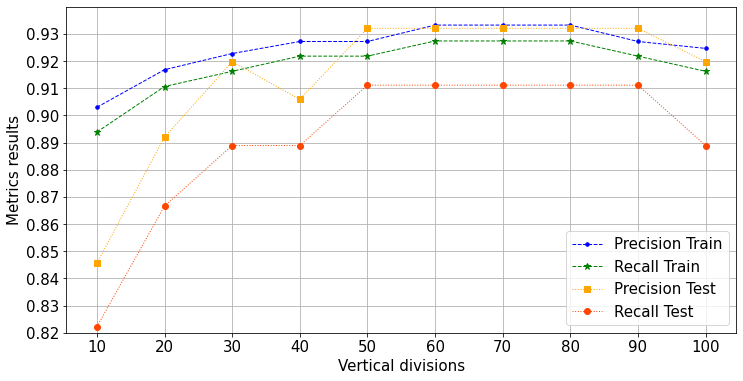

,width,precision_train,recall_train,f1_score_train,precision_test,recall_test,f1_score_test
0,10,0.9030,0.8939,0.8936,0.8457,0.8222,0.8217
0,20,0.9168,0.9106,0.9108,0.8920,0.8667,0.8677
0,30,0.9228,0.9162,0.9163,0.9198,0.8889,0.8899
0,40,0.9272,0.9218,0.9219,0.9059,0.8889,0.8898
0,50,0.9272,0.9218,0.9219,0.9320,0.9111,0.9121
0,60,0.9332,0.9274,0.9275,0.9320,0.9111,0.9121
0,70,0.9332,0.9274,0.9275,0.9320,0.9111,0.9121
0,80,0.9332,0.9274,0.9275,0.9320,0.9111,0.9121
0,90,0.9272,0.9218,0.9219,0.9320,0.9111,0.9121
0,100,0.9246,0.9162,0.9162,0.9198,0.8889,0.8899


In [6]:
widths = [10,20,30,40,50,60,70,80,90,100]
final_data = pd.DataFrame()
for w in range(0,len(widths)):
    info_results = []    
    file_name = 'data/info_h_'+str(widths[w])
    sections_width = int(file_name.split("_")[-1])
    data = prepare_data(file_name, data_category)   
    size_m = sections_width
    columns = ['h_'+str(a) for a in range(1,size_m+1)] #+ ['pw_'+str(a) for a in range(1,size_m+1)]
    X_values = data[columns]
    y_values = data[['category']]
    X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
    kmeans = SVC(C=C_value, class_weight=class_weight_value, random_state=seed) #KNeighborsClassifier(n_neighbors=6, p=4) #GaussianNB() # 
    kmeans.fit(X_train, y_train.values.ravel())
    y_predict = kmeans.predict(X_train)
    precision_train = (precision_score(y_train, y_predict, average='weighted'))
    recall_train= (recall_score(y_train, y_predict, average='weighted'))
    f1_score_train = f1_score(y_train, y_predict, average='weighted')
    y_predict = kmeans.predict(X_test)
    precision_test = (precision_score(y_test, y_predict, average='weighted'))
    recall_test = (recall_score(y_test, y_predict, average='weighted'))
    f1_score_test = f1_score(y_test, y_predict, average='weighted')
    data_row= [ widths[w], precision_train, recall_train,precision_test,recall_test, f1_score_train, f1_score_test]
    info_results.append(data_row)
    info_results =pd.DataFrame(info_results, columns=['width','precision_train', 'recall_train', 'precision_test','recall_test', 'f1_score_train', 'f1_score_test']) 
    final_data = pd.concat([final_data, info_results])

max_value = final_data[['precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test']].values.max() + 0.01
min_value = final_data[['precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test']].values.min() - 0.01

plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(1,1, figsize=(12,6))
#axs.title.set_text("Train results")
axs.plot(final_data.width,final_data.precision_train,marker='.',linestyle='dashed', color='blue',linewidth=1,markersize=7, label='Precision Train')
axs.plot(final_data.width,final_data.recall_train,marker='*',linestyle='dashed',color='green',linewidth=1,markersize=7, label='Recall Train')
#axs.plot(final_data.width,final_data.f1_score_train,marker='*',linestyle='dashed',color='orange',linewidth=0.5,markersize=5, label='F1-Score Train')
#axs.legend()
#axs.set_ylim([min_value, max_value])

#axs.title.set_text("Test results")
axs.plot(final_data.width,final_data.precision_test,marker='s',linestyle='dotted', color='orange',linewidth=1,markersize=6, label='Precision Test')
axs.plot(final_data.width,final_data.recall_test,marker='o',linestyle='dotted',color='orangered',linewidth=1,markersize=6, label='Recall Test')
#axs.plot(final_data.width,final_data.f1_score_test,marker='*',linestyle='dotted',color='orange',linewidth=0.5,markersize=5, label='F1-Score Test')
axs.legend()
#axs.set_ylim([min_value, max_value])

axs.set_ylim([0.82,0.94])
axs.set_xlabel('Vertical divisions')
axs.set_ylabel('Metrics results')
axs.grid()
axs.set_xticks(final_data.width)
axs.set_yticks(np.arange(0.82, 0.94, 0.01))
plt.savefig('final_results.jpg', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

final_data = final_data.reindex(['width', 'precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test'], axis=1)
#final_data = final_data.sort_values(by=['f1_score_test', 'f1_score_train'], ascending=False)
final_data = final_data.round(4)
final_data.to_latex('final_data.txt', index = False)
final_data

## Confusion matrix of best model

              precision    recall  f1-score   support

           k       0.86      0.97      0.91        67
           s       0.97      0.86      0.91        79
           b       1.00      1.00      1.00        33

    accuracy                           0.93       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.93      0.93      0.93       179

              precision    recall  f1-score   support

           k       0.76      1.00      0.87        13
           s       1.00      0.80      0.89        20
           b       1.00      1.00      1.00        12

    accuracy                           0.91        45
   macro avg       0.92      0.93      0.92        45
weighted avg       0.93      0.91      0.91        45



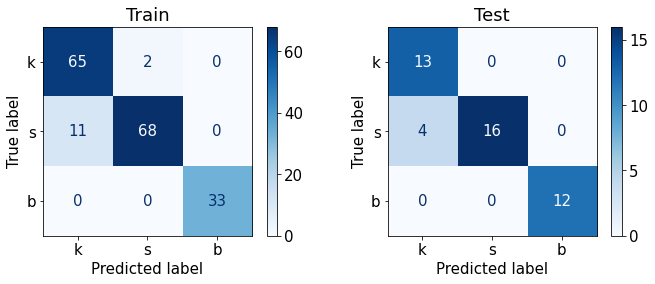

In [7]:
file_name = 'data/info_h_60'
sections_width = int(file_name.split("_")[-1])
data = prepare_data(file_name, data_category)
size_m = sections_width
columns = ['h_'+str(a) for a in range(1,size_m+1)] #+ ['pw_'+str(a) for a in range(1,size_m+1)]
X_values = data[columns]
y_values = data[['category']]
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
svc = SVC(C=8, class_weight='balanced', random_state=seed)#KNeighborsClassifier(n_neighbors=3)#SVC(C=5, class_weight='balanced')#
svc.fit(X_train, y_train.values.ravel())
y_predict_train = svc.predict(X_train)
precision_train = (precision_score(y_train, y_predict_train, average='weighted'))
recall_train= (recall_score(y_train, y_predict_train, average='weighted'))
y_predict = svc.predict(X_test)
precision_test = (precision_score(y_test, y_predict, average='weighted'))
recall_test = (recall_score(y_test, y_predict, average='weighted'))
data_row= [ precision_train, recall_train,precision_test,recall_test]

print(classification_report(y_train.values.ravel(),y_predict_train, target_names=['k', 's', 'b']))
print(classification_report(y_test.values.ravel(),y_predict, target_names=['k', 's', 'b']))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plot_confusion_matrix(svc,X_train, y_train.values.ravel(),ax=axes[0], cmap='Blues',display_labels=['k', 's', 'b'])
axes[0].title.set_text('Train')
plot_confusion_matrix(svc,X_test, y_test.values.ravel(),ax=axes[1], cmap='Blues',display_labels=['k', 's', 'b'])
axes[1].title.set_text('Test')
plt.tight_layout()
plt.savefig('final_confusion_matriz.jpg', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()